# Augmented Sketch Classification

Gabriel Ryan (gr2547)

Abhijit Suprem (asf2182)

## Introduction:

Sketch classification is an inherently difficult problem due the lack of information in most sketches and inconsistencies in how objects are drawn. Unlike images, sketches usually don't include information about textures and others details, instead only having an outline of the object. In addition people will use varying levels of abstraction in their sketches, resulting in sketches that vary from fairly realistic representations to completely symbolic abstractions. This variation can be seen in the following examples of sketches of monkeys:
<table>
<tr>
    <td> <img src="https://s3.amazonaws.com/gryan-content/dlcv_report/monkey2.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="https://s3.amazonaws.com/gryan-content/dlcv_report/monkey1.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="https://s3.amazonaws.com/gryan-content/dlcv_report/monkey3.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="https://s3.amazonaws.com/gryan-content/dlcv_report/monkey4.png" alt="Drawing" style="width: 250px;"/> </td>
</tr>
</table>

While the first sketch seems fairly realistic, the following three sketches are increasingly abstract. However, these sketches still contain information in markings and shape of the face, belly, and tail that make them recognizable as monkeys in the middle two sketches. This suggests that when our brains perform classification and recognition, they are able to learn those abstractions from real life images of monkeys.

This project replicates that process by using processed real life images to improve classification of sketches. Our hypothesis is that networks could learn to identify and pick out the same patterns that our brains do when recognizing an image, and thus be able to learn classify sketches even if that sketch does not directly resemble sketches used in training.

The most widely used dataset for sketch classification is the TU-Berlin sketch dataset [1], which consists of 250 classes with 80 samples per class. The current best performance on it uses an ensemble of 5 networks that classify each step of the sketch and achieves an accuracy of 77.6% [2].

We demonstrate that preprocessing images to resemble sketches and using them as additional training data for classification on the TU-Berlin dataset improves performance. Specifically, for the a 3 class sample of the dataset, we were able to go from 85.0 to 90.1% by incorporating processed images into the training data. Unfortunately, the image processing was time consuming and we were unable to process enough images to test more classes, however, we believe the substantial improvement of performance on this sample is a convincing proof of concept.


In [49]:
import os, fnmatch
import h5py
import pdb
import matplotlib.pyplot as plt
import time, pickle, pandas
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers
import bsds_seg_gen as bs_utils
from color_smoothing import l0_smooth
from pylab import rcParams
from tqdm import tqdm
import scipy.ndimage as ndimage
import glob
import seaborn as sns
import utils
import pandas as pd
import re

sns.set_style('white')
%matplotlib inline

## Sketchification:

In order to make images look like sketches, we trained a small network to perform binary classification of pixels using the Berkeley Segmentation Dataset and Benchmark [3]. 

In [12]:
# dimensions of our patches.
img_width, img_height = 23, 23
imageset = glob.glob('./imgs/*.jpg')
#Padding constants
im_pad,im_half_pad = 23,11
#This is for resizing - we want to generate edges faster
maxsize = (224, 224)

We use a small network with 2 convolutions a single dense output that classifies pixels as either edges or whitespace. For loss we found mean squared error was more effective that binary crossentropy for creating sketch like images.

In [9]:
model = Sequential()
model.add(Conv2D(32, (5,5) ,input_shape=(img_width, img_height, 3), strides=(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(256, (3,3),  strides=(2,2)))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

model.compile(loss = 'mean_squared_error',
              optimizer = 'rmsprop',
              metrics=['accuracy'])


model.load_weights("final_models/smoothed_dense_v2_2.hdf5")

for layer in model.layers:
    layer.trainable = False
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 7, 7, 32)          2432      
_________________________________________________________________
activation_5 (Activation)    (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 256)         73984     
_________________________________________________________________
activation_6 (Activation)    (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2305      
Total params: 78,721
Trainable params: 0
Non-trainable params: 78,721
_________________________________________________________________
None


Each image is sketchified by passing a 23x23 pixel window over the image and classifying each individual as either an edge or whitespace.

In [19]:
tstIm = Image.open(imageset[0])
tstIm.thumbnail(maxsize, Image.ANTIALIAS)

im = np.asarray(tstIm)
#Pad the outside - necessary to get the edges right.
im2=np.pad(im,((im_half_pad,im_half_pad),(im_half_pad,im_half_pad),(0,0)),"edge")

i,j=im_half_pad,im_half_pad
tm = time.time()
#Initialize the output matrix
edge_result=np.zeros((im.shape[0],im.shape[1]))
while i < im2.shape[0]-im_half_pad:
    while j < im2.shape[1]-im_half_pad:
        #Generate the patch
        im_patch = np.expand_dims(im2[i-im_half_pad:i+im_half_pad+1,j-im_half_pad:j+im_half_pad+1,:],axis=0)
        #pass it through the network
        edge_result[i-im_half_pad,j-im_half_pad] = model.predict(im_patch,1)[0,0].astype("uint8")
        j += 1
    i += 1
    j = im_half_pad
#Display the Image
sketchified_img = Image.fromarray((1-edge_result.astype("uint8"))*255)

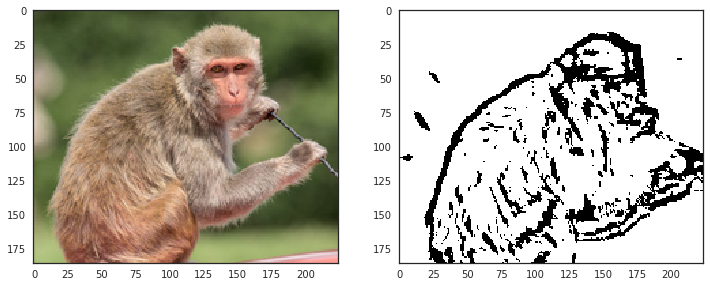

In [28]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(tstIm)
plt.subplot(1,2,2)
plt.imshow(sketchified_img, cmap='gray')

## Preprocessing:

Although the images produced by the edge detection network are closer to sketches, there is still much more detail and fine grained textures in them than can found in the sketches in the TU-Berlin dataset. We therefore experimented with smoothing filters and thresholding to emphasize and smooth thick edges and remove small details and textures.

We found that iteratively applying a filter of 1s with 2 in the center and then thresholding on the value 0.5 (on an image scaled from 0 to 1) was effective in making the image look more like a sketch:

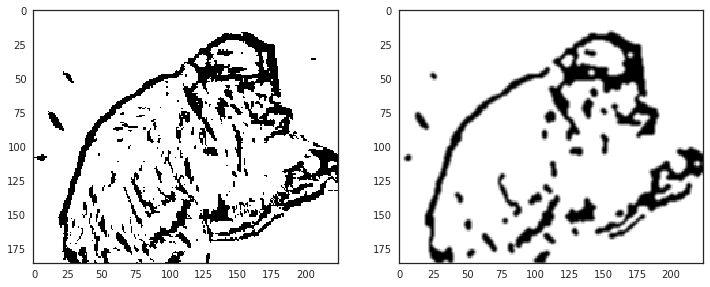

In [35]:
def scale(img):
    return img.astype('float64') * 1.0/ float(img.max())
    
def convolve(img, n, thresh):
    k = np.ones((3,3))
    k[1,1] = 2.0
    
    for _ in xrange(n):
        img[img > thresh] = 1.0
        img[img < thresh] = 0.0
        img = scale(ndimage.convolve(img, k, mode='constant', cval=1.0))

    return img

preprocessed_img = np.copy(sketchified_img)
for i in xrange(10):
    preprocessed_img = scale(preprocessed_img)
    preprocessed_img = convolve(preprocessed_img, n=10, thresh=0.5)
    
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(sketchified_img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(preprocessed_img, cmap='gray')

## Proof of concept test:

Once we had a working pipeline for generating images that look like sketches, we built an augmented dataset of 50 sketchified images in 3 classes, monkeys, giraffes, and cows. We combined this with the TU-Berlin dataset to create 3 class classification data set with 103 training images (50 sketchified images and 53 TU-Berlin sketches), and 27 test images (all from TU-Berlin). We also applied the same filter/thresholding routine to the TU-Berlin data into order to thicken and soften its edges similarly to the preprocessed images, although we found fewer iterations were necessary to achieve a similar appearance.

We then trained 2 identical networks, one with only the TU-Berlin data, and one with the combined training data. For our network we use smaller VGG style network, with 5 3x3 convolutional layers and 2 2056 fully connected layers.

Below we demonstrate using the image to classify a sketch of a monkey from the TU Berlin dataset.


In [2]:
model = None
load_name = 'augmented1'
with open('../models/'+load_name+'/model.json', 'r') as f:
    model = model_from_json(f.read())
    model.load_weights('../models/'+load_name+'/best.h5')
    

opt = optimizers.rmsprop()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
layer1 (Conv2D)              (None, 256, 256, 64)      36928     
_________________________________________________________________
layer2 (MaxPooling2D)        (None, 128, 128, 64)      0         
_________________________________________________________________
layer3 (Conv2D)              (None, 128, 128, 128)     73856     
_________________________________________________________________
layer4 (MaxPooling2D)        (None, 64, 64, 128)       0         
_________________________________________________________________
layer5 (Dropout)             (None, 64, 64, 128)       0         
_________________________________________________________________
layer6 (Conv2D)              (None, 64, 64, 256)       295168    
__________

In [23]:
metrics = model.evaluate_generator(validation_generator, steps=8)
print 'val', model.metrics_names, metrics

val ['loss', 'acc'] [0.35002783192715176, 0.90140842719816827]


## Training:

In order to simulate the wide variety of variation in sketches, we used aggressive data augmentation in training. We used a data generator with random shears and zooms of up to 25%, rotations of +=35 degrees, and horizonal flips. 

For optimization we used rmsprop with a learning rate of 0.0001 for 20 epochs, 0.00005 for 10 epochs, and 0.00001 for 10 epochs. For our reference network we trained for twice as many epochs since there were roughly half as many training samples. We found these relatively low learning rates produced good convergence on sketches, while higher learning rates tended to cause the network to diverge. We theorize this is because the sparsity of information in sketches makes the networks much more sensitive during training. We also tried Adam as an alternative optimizer to rmsprop but found that it performed slightly worse in terms of best accuracy achieved. 

We used a batch size of 10, which is slightly more than 3 times the number of classes.

In [12]:
batch_size = 10

data_root = '../data/combined/'
train_data_dir = data_root + 'train'
validation_data_dir = data_root + 'test'

train_datagen = ImageDataGenerator(
        shear_range=0.25,
        zoom_range=0.25,
        rotation_range=35,
        horizontal_flip=True)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

def classname(y):
    yind = np.argwhere(y==1)
    return ['cow', 'giraffe', 'monkey'][yind[0][0]]

Found 309 images belonging to 3 classes.
Found 81 images belonging to 3 classes.


We show several examples of training data. Many of the sketchified examples are difficult to recognize, but still seem to contain some useful patterns for classification, such as facial patterns on the monkeys.

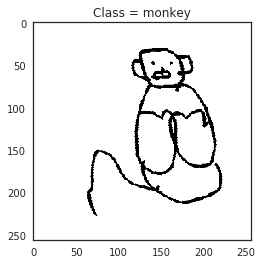

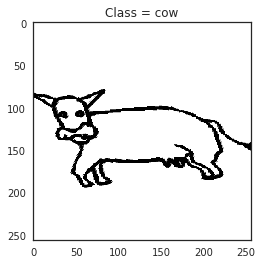

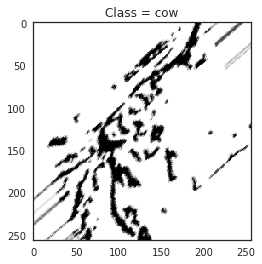

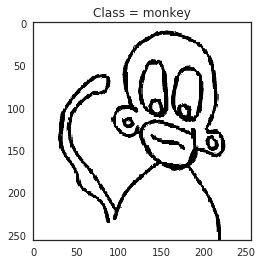

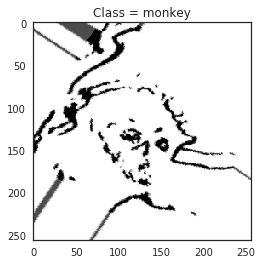

In [14]:
# show 5 training examples
batch, y = train_generator.next()
for i in xrange(5):
    utils.show_sample(batch[i], classname(y[i]))

For convenience we wrote a training class that handles setting up checkpoints and adjusting the learning rate. Here we use it to train for a single epoch:

In [5]:
trainer =  utils.ModelTrainer(
                 model,
                 'combined',
                 opt,
                 train_generator,
                 validation_generator,
                 train_steps=31,
                 val_steps=8)

trainer.train(epochs=1, lr=0.00001)

Epoch 1/1
31/31 [==============================] - 26s - loss: 0.6054 - acc: 0.7341 - val_loss: 0.3646 - val_acc: 0.8625


Here we show several test images and predictions. Generally the network seems to get sketches correct when they are easily distinguishable, and makes mistakes that make sense, such classifying crawling monkeys as cows.

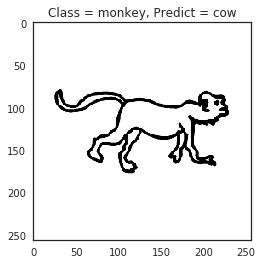

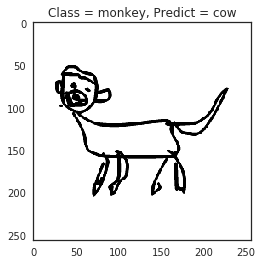

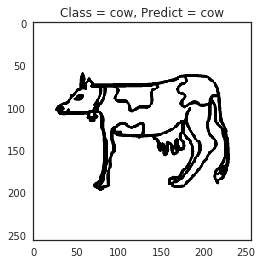

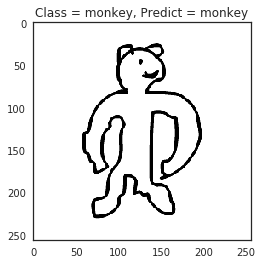

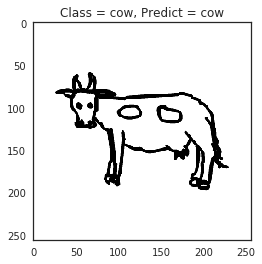

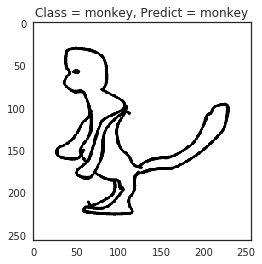

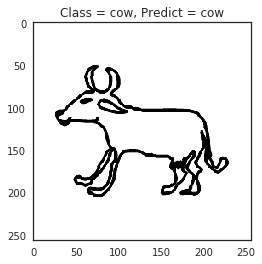

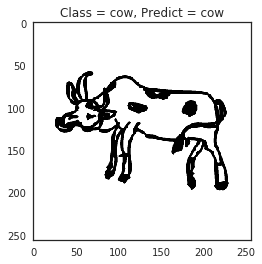

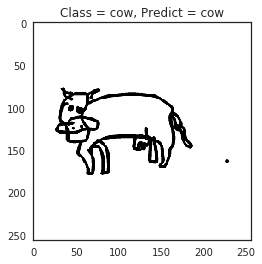

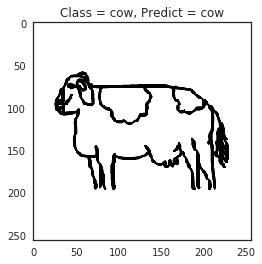

In [13]:
imgs, ys = validation_generator.next()
yps = model.predict(imgs)
for img, y, yp in zip(imgs, ys, yps):
    yp2 = np.zeros(yp.size)
    yp2[np.argmax(yp)] = 1
    utils.show_sample(img, classname(y), classname(yp2))

### Results

A comparison of the two networks shows a clear advantage for the augmented training data set, which achieves a best performance validation accuracy of 90.1%, compared to 85.0% for the original data.

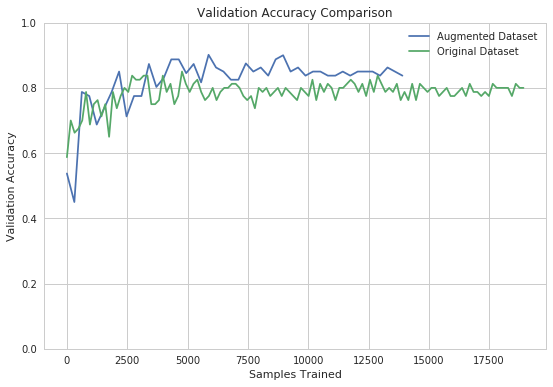

In [16]:
aug = pd.read_csv('../results/run_augmented1,tag_val_acc.csv')
ref = pd.read_csv('../results/run_reference1,tag_val_acc.csv')

xaug = np.arange(len(aug['Value']))
xaug = xaug * 309

xref = np.arange(len(ref['Value']))
xref = xref * 53*3

sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
plt.plot(xaug, aug['Value'])
plt.plot(xref, ref['Value'])
plt.gca().set_ylim([0,1])
plt.title('Validation Accuracy Comparison')
plt.legend(['Augmented Dataset', 'Original Dataset'])
plt.ylabel('Validation Accuracy')
plt.xlabel('Samples Trained')

In [22]:
print 'max accuracy original:',round(np.max(ref['Value']),3),\
    'max accuracy augmented:',round(np.max(aug['Value']),3)

max accuracy original: 0.85 max accuracy augmented: 0.901


## Testing on full dataset:

In addition to conducting our experiment with sketchified images, we attempted to train a larger network on the full TU Berlin dataset. Designed our network based on the Deepsketch2 network, which has 4 convolutional layers and kernels of 7x7 and 5x5 for the 2 first layers, as well as 3x3 maxpooling layers. However, to improve the models ability to fit data we added additional 3x3 convolutional layers after each original convolutional layer, and switched to 2x2 maxpooling, thereby increasing the width and depth of each convolutional layer. To compensate for the additional parameters and prevent overfitting, we also added additional dropout after convolutional layer.

We found that the model was extremely sensitive during training, and used rmsprop with a training rate of 0.00001, with backoff factor 0.5 and patience of 5 epochs.

We applied the same filter used in our proof of concept experiment since it improved model performance and also used the same aggressive data augmentation settings for training on the full data set.

In [39]:
batch_size = 25

data_root = '../data/tu-berlin-filtered/'
train_data_dir = data_root + 'train'
validation_data_dir = data_root + 'test'

train_datagen = ImageDataGenerator(
        shear_range=0.25,
        zoom_range=0.25,
        rotation_range=35,
        horizontal_flip=True)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

Found 13250 images belonging to 250 classes.
Found 6750 images belonging to 250 classes.


In [40]:
model = None
load_name = 'deepsketch4'
with open('../models/'+load_name+'/model.json', 'r') as f:
    model = model_from_json(f.read())
    model.load_weights('../models/'+load_name+'/best.h5')
    

opt = optimizers.rmsprop()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      3200      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       204928    
__________

Here we perform a single training iteration. As can be seen in the relatively low training loss/validation loss the model has already overfit.

In [43]:
trainer =  utils.ModelTrainer(
                 model,
                 'deepsketch4-test',
                 opt,
                 train_generator,
                 validation_generator,
                 train_steps=530,
                 val_steps=270)

trainer.train(epochs=1, lr=0.000001)

Epoch 1/1
530/530 [==============================] - 310s - loss: 1.2478 - acc: 0.6752 - val_loss: 1.8288 - val_acc: 0.6188


Now we look at some predictions. Generally predictions make intuitive sense -- when there are mistakes it is because the sketch resembles something else, such as the suitcase which looks like a tv. However there are still mistakes that a human could easily get right, such as the tree that is mistaken for a mail box.

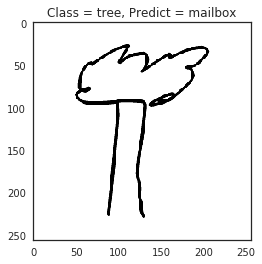

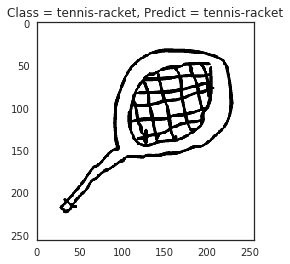

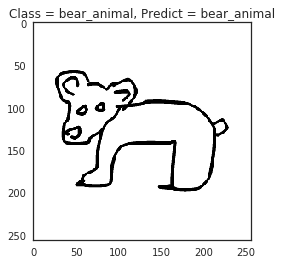

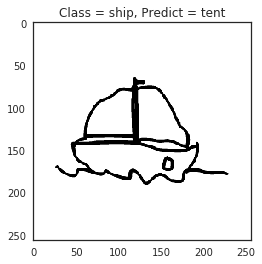

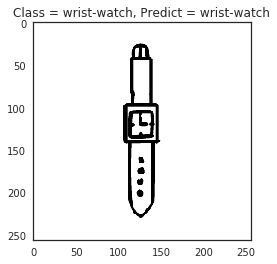

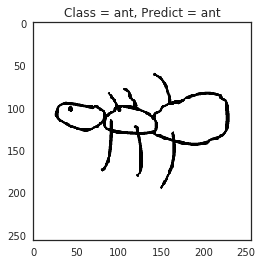

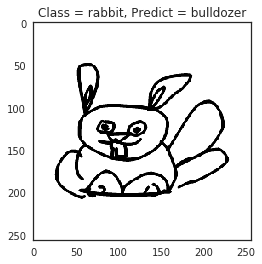

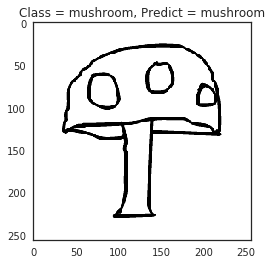

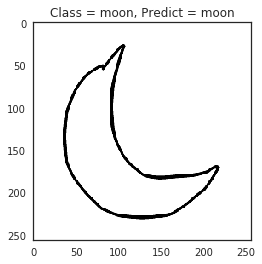

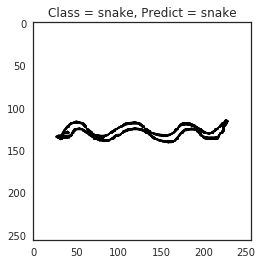

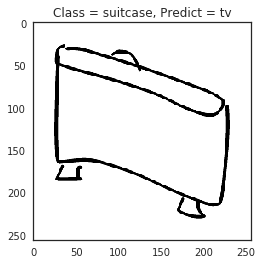

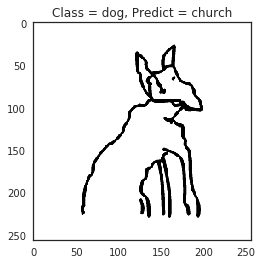

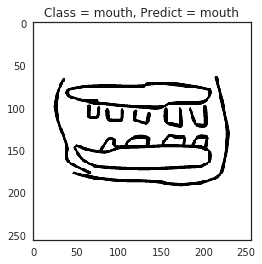

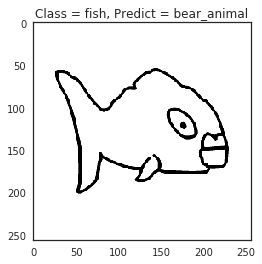

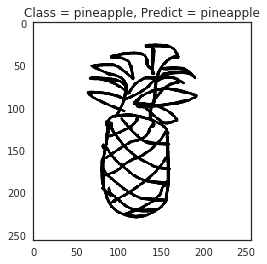

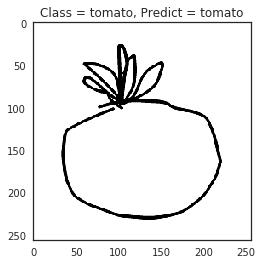

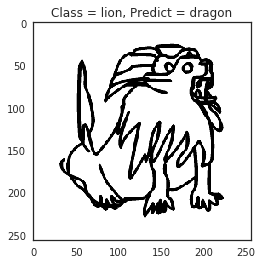

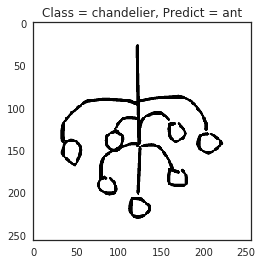

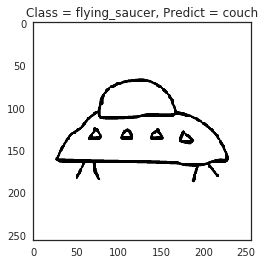

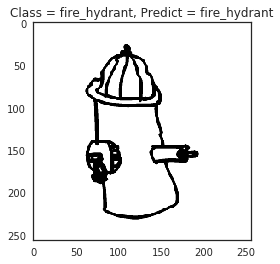

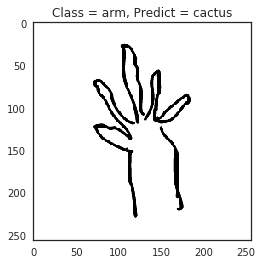

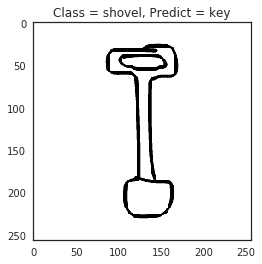

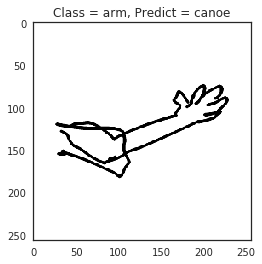

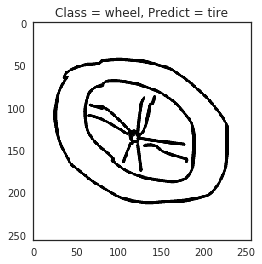

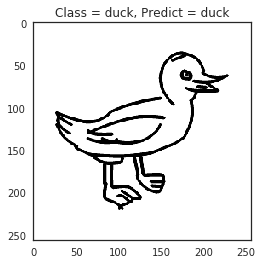

In [55]:
sns.set_style('white')
classes = sorted(glob.glob('../data/tu-berlin-filtered/train/*'))
classes = list(map(lambda s :re.match('.*/([\w_-]+)$', s).group(1), classes))

imgs, ys = validation_generator.next()
yps = model.predict(imgs)
for img, y, yp in zip(imgs, ys, yps):
    utils.show_sample(img, classes[np.argmax(y)], classes[np.argmax(yp)])

Accuracy only reached 62.2% and the model appears to have started to overfit after the 110th epoch, although the best validation accuracy was achieved on the 204th epoch. We suspect the reason for the relatively poor performance is that we did not evaluate using the same method used by other groups, who take the average prediction of 10 predictions with the image shifted and flipped in various parts of the frame. It seems likely that using this method would boost performance significantly and we consider it an important next step in our evaluation.

In [38]:
acc = pd.read_csv('../results/deepsketch4_acc.csv')
loss = pd.read_csv('../results/deepsketch4_loss.csv')
print 'max accuracy original:',round(np.max(acc['Value']),3),'epoch:',np.argmax(acc['Value'])

max accuracy original: 0.622 epoch: 204


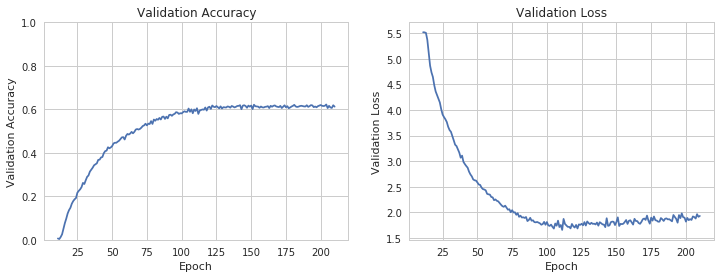

In [35]:
start_ind = 11
acc = acc['Value'][start_ind:]
sns.set_style('whitegrid')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(acc)
plt.gca().set_ylim([0,1])
plt.title('Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.subplot(1,2,2)
plt.plot(loss['Value'][start_ind:])
plt.title('Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.show()

## Conclusions

We provide a new method of generating training data for a difficult problem (sketch recognition) where availability of training data is an issue, and demonstrate its effectiveness by using the additional training data to achieve a 1/3 reduction in error rate on a 3 class sketch classification problem.

We also find that for sketches rmsprop is the most effective optimization method, and that very low learning rates are necessary to prevent the network from diverging during training.

Future work will involve scaling up the image to sketch conversion to generate enough sketches to test on the full dataset. Since the current per pixel method is very slow (1-3 minutes per image), this will require switching to a more recent image segmentation method that can convert an entire image at once. 

Whether the additional generated data is equally effective in improving model performance on larger classification tasks will need to be tested. One possibility is that the additional noise of the sketchified images simply made the model more general, and another regularization method such as dropout or gaussian noise could have had the same effect.

On the recognition side, implementing an evaluation that shifts and flips test images will allow us to evaluate how our models compare to existing state of the art. Another possibility that may have a similar effect is to automatically crop all images so the sketch fills the input image. 

There is also ample room for further experimentation with model architectures, such as using correlation instead of convolution layers, or using resnet and inception style networks.

## Attribution:

Per pixel sketchification of images was developed primarily by Abhijit Suprem. I (Gabriel Ryan) primarily developed the image preprocessing and sketch recognition networks.

## References

1. Mathias Eitz, James Hays, and Marc Alexa. 2012. How do humans sketch objects?. ACM Trans. Graph. 31, 4, Article 44 (July 2012), 10 pages. DOI=http://dx.doi.org/10.1145/2185520.2185540
2. O. Seddati, S. Dupont and S. Mahmoudi, "DeepSketch 2: Deep convolutional neural networks for partial sketch recognition," 2016 14th International Workshop on Content-Based Multimedia Indexing (CBMI), Bucharest, 2016, pp. 1-6.
3. Martin, David R. et al. “A Database of Human Segmented Natural Images and its Application to Evaluating Segmentation Algorithms and Measuring Ecological Statistics.” ICCV (2001).